In [25]:
import torch
import losslandscape as land
import matplotlib.pyplot as plt

from models import TransformerModelLooped, TransformerModelLoopedPyHessianWrapper, TransformerModelPyHessianWrapper
from curriculum import CurriculumSimple
from train import train_without_config, validate_model


n_dims = 10
train_steps = 100
log_every = 10
device = "cuda:0"

In [26]:
model_loop_b5 = TransformerModelLoopedPyHessianWrapper(
    n_dims=n_dims,
    n_positions=101,
    n_embd=128,
    n_layer=1,
    n_head=4,
    pred_type="regression",
    default_n_loops=5
).to(device)

cirriculum_b5 = CurriculumSimple(n_dims, 31, 5, [5000, n_dims, 0], [5000, 31, 0], [1000, 5, 0])

log_steps = train_steps // log_every

params = []
losses = [] 

def callback_fn(model, loss):
    params.append(land.ParamList(land.get_params(model)))
    losses.append(loss)

metrics_l1_b5 = train_without_config(
    model_loop_b5, cirriculum_b5, model_n_dims=n_dims,
    log_every_steps=log_every, train_steps=train_steps, family="gpt2_loop",
    do_wandb_log=False, seed=None, task_name="noisy_linear_regression", callback=callback_fn)

number of parameters: 0.20M


  0%|          | 0/100 [00:00<?, ?it/s]

0


loss 9.229998588562012: 100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


In [27]:
losses = torch.tensor(losses).to(device)

In [28]:
theta0 = params[0]
for i in range(1, len(params)):
    theta0 = theta0 + params[i]
theta0 = theta0 / len(params)

theta0 = params[-1]

In [31]:
params[0].params.__len__()

19

In [5]:
def criterion_fn(y_pred_list, ys):
    y_pred_arr = torch.cat(y_pred_list, dim=0)  # [B * K, n]
    y_star_arr = torch.cat([ys] * len(y_pred_list), dim=0)  # [B * K, n]
    return (y_star_arr - y_pred_arr).square().mean()

In [6]:
from scripts.tasks import get_task_sampler

task_sampler = get_task_sampler(
    task_name="noisy_linear_regression",
    batch_size=1,
    n_points=31,
    n_dims=10,
    n_dims_truncated=10,
    device=device,
)

real_task = task_sampler()
xs, ys = real_task.xs.float(), real_task.ys.float()

In [13]:
loss_landscape = land.LossLandscapePlotting(
    model=model_loop_b5,
    criterion= criterion_fn,
    device=device,
    data=(torch.concatenate([xs, ys.unsqueeze(-1)], dim=-1), ys),
    parameters_history=params,
    loss_history=losses,
    theta0=theta0
)

Computing eigenvectors at providen data...


In [14]:
trace = loss_landscape.compute_trace(every_ith=1)

Computing trace...


30it [00:53,  1.78s/it]                        


In [9]:
ralpha, rbeta, surface = loss_landscape.compute_landscape(trace, arange=(-1, 1), brange=(-1, 1), grid_density=100, coef=1)

Making surface...


100%|██████████| 10000/10000 [02:22<00:00, 70.20it/s]


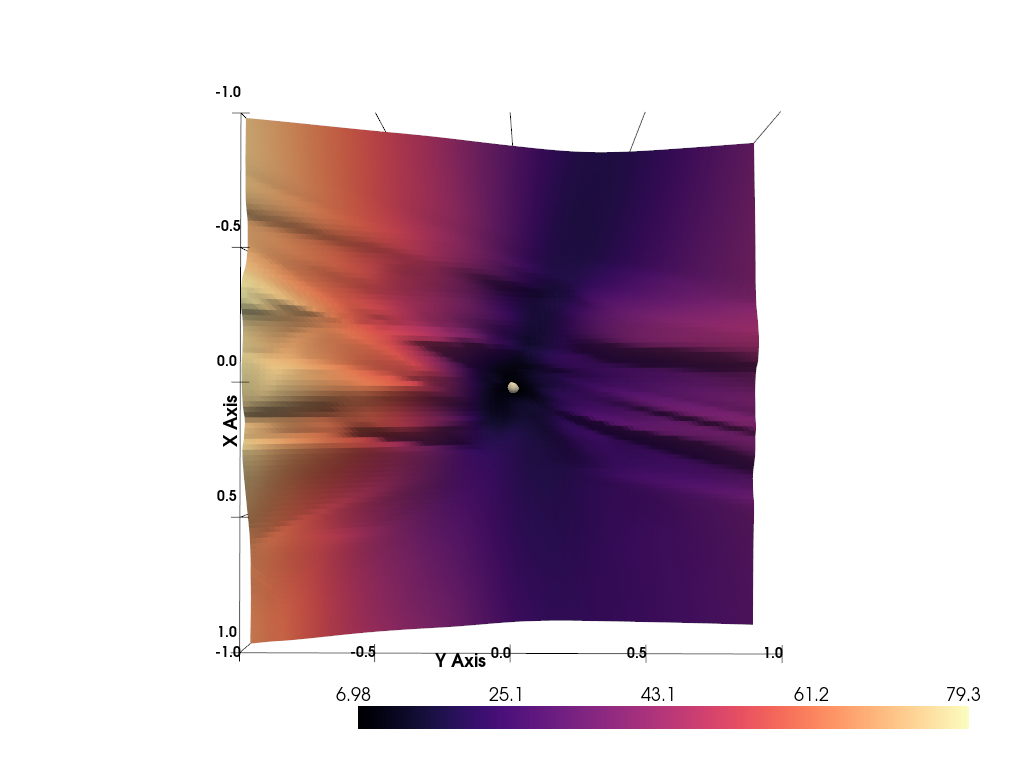

In [10]:
loss_landscape.plot(
    trace=trace, # [trace[0], trace[-1]],
    ralpha=ralpha, rbeta=rbeta, surface=surface,
    colormap="magma", k=0.5
)

In [12]:
trace

array([[ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137085e-03, -2.47774842e-03,  6.77012014e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137085e-03, -2.47774842e-03,  6.77012014e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03,  6.77014542e+00],
       [ 6.98137622e-03, -2.47774400e-03

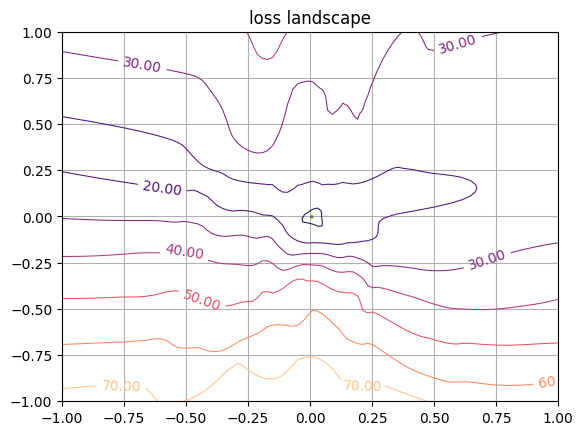

In [11]:
loss_landscape.plot_contour(
    trace=trace,
    ralpha=ralpha, rbeta=rbeta, surface=surface,
    colormap="magma", k=1
)

In [46]:
model_l2 = TransformerModelPyHessianWrapper(
    n_dims=n_dims,
    n_positions=101,
    n_embd=128,
    n_layer=2,
    n_head=4,
    pred_type="regression"
).to(device)

cirriculum_l2 = CurriculumSimple(n_dims, 31, 0, [5000, n_dims, 0], [5000, 31, 0], [1000, 0, 0])

train_steps = 15000
log_every = 500

l2_log_steps = train_steps // log_every
l2_params = []
l2_losses = []

def callback_fn(model, loss):
    l2_params.append(land.ParamList(land.get_params(model)))
    l2_losses.append(loss)

metrics_l2 = train_without_config(
    model_l2, cirriculum_l2, model_n_dims=n_dims,
    log_every_steps=log_every, train_steps=train_steps, family="gpt2",
    do_wandb_log=False, seed=None, task_name="noisy_linear_regression", callback=callback_fn)

number of parameters: 0.40M


loss 3.555921792984009: 100%|██████████| 15000/15000 [04:32<00:00, 54.97it/s] 


In [58]:
l2_losses = torch.tensor(l2_losses).to(device)
# theta0 = l2_params[0]
# for i in range(1, len(l2_params)):
#     theta0 = theta0 + l2_params[i]
# theta0 = theta0 / len(l2_params)

theta0 = l2_params[-1]

In [59]:
def criterion_fn(y_pred, ys):
    return (ys - y_pred).square().mean()


from scripts.tasks import get_task_sampler

task_sampler = get_task_sampler(
    task_name="noisy_linear_regression",
    batch_size=1,
    n_points=31,
    n_dims=10,
    n_dims_truncated=10,
    device=device,
)

real_task = task_sampler()
xs, ys = real_task.xs.float(), real_task.ys.float()

loss_landscape = land.LossLandscapePlotting(
    model=model_l2,
    criterion=criterion_fn,
    device=device,
    data=(torch.concatenate([xs, ys.unsqueeze(-1)], dim=-1), ys),
    parameters_history=l2_params,
    loss_history=l2_losses,
    theta0=theta0
)
  

Computing eigenvectors at providen data...


In [60]:
trace = loss_landscape.compute_trace(every_ith=1)
ralpha, rbeta, surface = loss_landscape.compute_landscape(trace, arange=(-1, 1), brange=(-1, 1), grid_density=250, coef=1)

Computing trace...


30it [00:41,  1.38s/it]                        


Making surface...


100%|██████████| 62500/62500 [07:43<00:00, 134.88it/s]


In [61]:
trace

array([[ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02,  2.67556381e+00],
       [ 1.68414256e-03, -1.79201440e-02

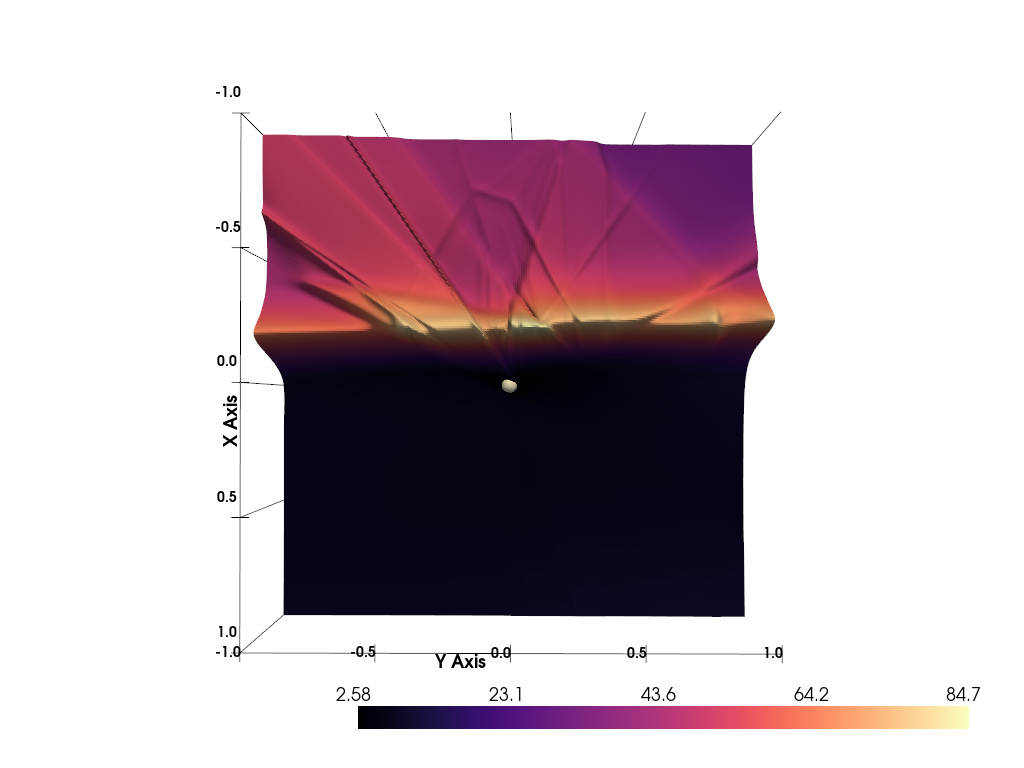

In [62]:
loss_landscape.plot(
    trace=trace,  # [trace[0], trace[-1]],
    ralpha=ralpha, rbeta=rbeta, surface=surface,
    colormap="magma", k=0.5
)

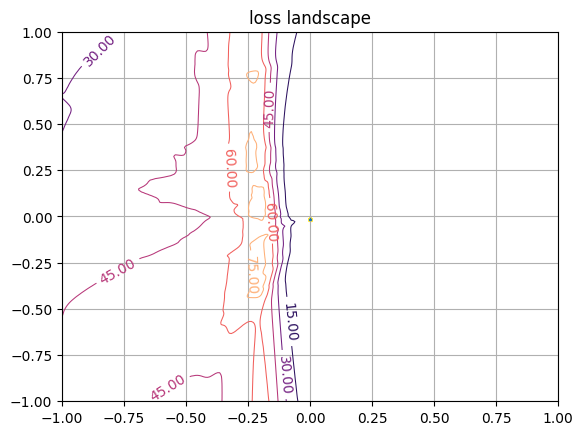

In [63]:
loss_landscape.plot_contour(
    trace=trace,
    ralpha=ralpha, rbeta=rbeta, surface=surface,
    colormap="magma", k=1
)